# Feature Engineering

In this notebook, I'll implement a core part of this project -- engineering several new features in the dataset that would help in predicting churn. 

To recap: We currently do not have enough features in our dataset to succesfully carry out predictions. Apart from details about transactions in 2022, there are only two other demographic features viz: `registration_type` and `industry` which provide some more information about our data. 

One major handicap is the fact that since my definition of churn relied on the `date` feature in my dataset, I cannot engineer new columns that are also dependent on time/date otherwise those features would be indicative of churn. For instance a feature like month over month change in credit or debit amounts OR month over month change in ledger_balance may have been useful for predictive purposes, but engineering those features would have relied on time and therefore indicative for our model.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

brass = pd.read_csv('../data/brass_churn.csv')

In [4]:
brass.head()

,id,registration_type,industry,transaction_type,amount,ledger_balance,available_balance,date,difference,churn
0,21,Enterprise,General Services,credit,10000,0,0,2022-07-16,169,0
1,21,Enterprise,General Services,debit,10000,10000,0,2022-07-17,168,0
2,122,Limited Liability,Technology,debit,1200000,2000000,2000000,2022-04-15,261,1
3,122,Limited Liability,Technology,credit,2000000,0,0,2022-04-15,261,1
4,159,Sole Proprietorship,Technology,debit,1200000,1200000,1200000,2022-05-05,241,0


# Features: `credit_count`, `debit_count`, `cred_count_ratio` and `deb_count_ratio`

Let's start with the first four features we want to create

- a feature representing the raw count of credit transactions.
- a feature representing the raw count of debit transactions.
- a feature representing the count of `credit` transactions per number of days since registration for each customer, and
- a feature representing the count of `debit` transactions per number of days since registration for each customer. 

### Throwback
Recall that in our first [notebook](./notebooks/01_introduction.ipynb), we created a dataframe called `min_diff` by grouping our main `brass` dataframe by unique id, and performing a `min` aggregation so that we could get the most recent transaction date. From the most recent transaction date, we derived the `difference` column which we used in selecting a cutoff for churn. 

We want to do something similar here. This time though, we would be creating a `max_diff` dataframe by performing a `max` aggregation after grouping the main `brass` df. We are using the `max` this time because we want the earliest transaction date in our dataset. This earliest transaction date would stand as proxy for the day that customer was registered since we do not have that. 

In [5]:
#Grouping by `id` and aggregating. Renaming this grouped dataframe as `max_diff`
max_diff = brass.groupby('id').max()

#Checking top 10 rows in grouped dataframe
max_diff.head(10)

,registration_type,industry,transaction_type,amount,ledger_balance,available_balance,date,difference,churn
id,,,,,,,,,
21,Enterprise,General Services,debit,10000,10000,0,2022-07-17,169,0
122,Limited Liability,Technology,debit,2000000,2000000,2000000,2022-04-15,261,1
159,Sole Proprietorship,Technology,debit,998000000,1012359487,415469625,2022-12-21,241,0
217,Limited Liability,Digital Services,debit,1300000,1300000,1300000,2022-05-26,220,1
323,Sole Proprietorship,Others,debit,2500000,4110115,4010115,2022-12-16,249,0
373,Limited Liability,E-Commerce,debit,50000000,83901548,49901548,2022-12-21,278,0
498,Limited Liability,Technology,debit,30000000,20008925,20008925,2022-12-30,23,0
686,Sole Proprietorship,E-Commerce,debit,100000000,102325835,82325835,2022-12-29,84,0
1108,Sole Proprietorship,Press & Media,debit,30100000,30622401,20544978,2022-12-29,362,0


In [6]:
#Using boolean filter to create a new dataframe containing only credit transactions
credit = brass[brass['transaction_type'] == 'credit']

#Group the credit dataframe by id and take the count of number of transactions. Name this grouped dataframe as credit_count
credit_count = pd.DataFrame(credit.groupby('id')['amount'].size())

#Merge credit_count with the max_diff df
max_diff = max_diff.merge(credit_count, on='id').rename(columns={'amount_x': 'amount', 'amount_y': 'credit_count'}) 

#Create cred_count_ratio column by dividing `credit_count` column by `diff` column 
max_diff['cred_count_ratio'] = max_diff['credit_count'] / max_diff['difference']

In [7]:
max_diff.head()

,registration_type,industry,transaction_type,amount,ledger_balance,available_balance,date,difference,churn,credit_count,cred_count_ratio
id,,,,,,,,,,,
21,Enterprise,General Services,debit,10000,10000,0,2022-07-17,169,0,1,0.005917
122,Limited Liability,Technology,debit,2000000,2000000,2000000,2022-04-15,261,1,1,0.003831
159,Sole Proprietorship,Technology,debit,998000000,1012359487,415469625,2022-12-21,241,0,9,0.037344
217,Limited Liability,Digital Services,debit,1300000,1300000,1300000,2022-05-26,220,1,1,0.004545
323,Sole Proprietorship,Others,debit,2500000,4110115,4010115,2022-12-16,249,0,21,0.084337


We now have the `credit_count` and `cred_count_ratio` columns we wanted.

Now we would do the same process to get the `debit_count` and  `deb_count_ratio` columns.

In [8]:
#Using boolean filter to create a new dataframe containing only debit transactions
debit = brass[brass['transaction_type'] == 'debit']

#Group the debit dataframe by id and take the count of number of transactions. Name this grouped dataframe as debit_count
debit_count = pd.DataFrame(debit.groupby('id')['amount'].size())

#Check the shape of this debit_count as compared to credit_count dataframe
print(debit_count.shape)
print(credit_count.shape)

(1348, 1)
(1493, 1)


### Observation
While the `credit_count` dataframe contained 1493 rows like the main `brass` dataframe, the `debit_count` dataframe contains fewer rows. 

### Why is this?
This is because there are some accounts which have never had a debit transaction yet, especially among the newly opened accounts (although - from an examination of the dataset - there are some older ones like that as well.) If I merge this `debit_count` df with our `max_diff`, there would be several rows missing or several NaN values (depending on the type of JOIN I use). 

### What to do?
I'll go ahead and do a merge using left join. This would create NaN values. For the sake of this project I would fill those NaN values with 0. That way the `debit_count` column as well as the `deb_count_ratio` column for those rows would both be 0. 

In [9]:
#Merge debit_count with the max_diff df
max_diff = max_diff.merge(debit_count, on='id', how='left').rename(columns={'amount_x': 'amount', 'amount_y': 'debit_count'})  

print(max_diff.shape)
max_diff.tail(5)

(1493, 12)


,registration_type,industry,transaction_type,amount,ledger_balance,available_balance,date,difference,churn,credit_count,cred_count_ratio,debit_count
id,,,,,,,,,,,,
51370,Sole Proprietorship,Leisure & Entertainment,credit,2210000,4210000,4210000,2022-12-29,9,0,3,0.333333,NaN
51445,Enterprise,Technology,credit,200000,0,0,2022-12-12,20,0,1,0.050000,NaN
51448,Enterprise,Fashion & Beauty,credit,200000,0,0,2022-12-13,19,0,1,0.052632,NaN
51451,Enterprise,Food & Beverage,credit,220000,0,0,2022-12-17,15,0,1,0.066667,NaN
51473,Enterprise,Leisure & Entertainment,credit,205000,0,0,2022-12-19,13,0,1,0.076923,NaN


As expected the number of rows is 1493, and the `debit_count` column (last column above) has several NaN values at the tail. 

Below I'll fill NaN values with 0.

In [10]:
max_diff['debit_count'].fillna(0, inplace=True)

In [11]:
#Checking - the NaN values have now been replaced
max_diff.tail()

,registration_type,industry,transaction_type,amount,ledger_balance,available_balance,date,difference,churn,credit_count,cred_count_ratio,debit_count
id,,,,,,,,,,,,
51370,Sole Proprietorship,Leisure & Entertainment,credit,2210000,4210000,4210000,2022-12-29,9,0,3,0.333333,0.0
51445,Enterprise,Technology,credit,200000,0,0,2022-12-12,20,0,1,0.050000,0.0
51448,Enterprise,Fashion & Beauty,credit,200000,0,0,2022-12-13,19,0,1,0.052632,0.0
51451,Enterprise,Food & Beverage,credit,220000,0,0,2022-12-17,15,0,1,0.066667,0.0
51473,Enterprise,Leisure & Entertainment,credit,205000,0,0,2022-12-19,13,0,1,0.076923,0.0


In [12]:
#Now we can create the `deb_count_ratio` column by dividing `debit_count` column by `diff` column 

max_diff['deb_count_ratio'] = max_diff['debit_count'] / max_diff['difference']

In [13]:
#Checking
max_diff.tail(10)

,registration_type,industry,transaction_type,amount,ledger_balance,available_balance,date,difference,churn,credit_count,cred_count_ratio,debit_count,deb_count_ratio
id,,,,,,,,,,,,,
51311,Unregistered Business,Digital Services,debit,20000,30000,30000,2022-12-17,25,0,17,0.680000,17.0,0.680000
51331,Enterprise,Agriculture,debit,27000000,32416373,30426373,2022-12-31,26,0,75,2.884615,40.0,1.538462
51333,Sole Proprietorship,Fashion & Beauty,credit,20000,0,0,2022-12-06,26,0,1,0.038462,0.0,0.000000
51356,Enterprise,Fashion & Beauty,debit,200000,200000,10000,2022-12-27,25,0,7,0.280000,8.0,0.320000
51367,Enterprise,Agriculture,debit,2487500,2537501,2537501,2022-12-30,18,0,4,0.222222,10.0,0.555556
51370,Sole Proprietorship,Leisure & Entertainment,credit,2210000,4210000,4210000,2022-12-29,9,0,3,0.333333,0.0,0.000000
51445,Enterprise,Technology,credit,200000,0,0,2022-12-12,20,0,1,0.050000,0.0,0.000000
51448,Enterprise,Fashion & Beauty,credit,200000,0,0,2022-12-13,19,0,1,0.052632,0.0,0.000000
51451,Enterprise,Food & Beverage,credit,220000,0,0,2022-12-17,15,0,1,0.066667,0.0,0.000000


As expected, the rows that had 0 in the `debit_count` columns also have 0 in the `deb_count_ratio` column, while we have other values in rows which had something other than 0 in the `debit_count` column.

We will come back to this max_diff dataframe at a later time when we need to merge those columns with our main dataframe. For now let's move on to another feature. 

# Feature: `is_high_value`

Next, we will create a feature representing high and low value customers. 

Here is how I am going to define this feature:
- High value customers are customers whose **mean credit transactions** hover close to the mean of the mean credit transactions of all customers. I am going with credit transactions as the metric here because it is less likely that a customer is churning if there are still inflows into its account. Also I am going with 'hover close' to the mean instead of 'greater than' the mean because from examination of this dataset in previous notebook, there are some outliers that heavily skew this mean. 

- Considering the above definition, we would use the `credit` only dataframe which we had created earlier via boolean filtering, sort it by `id` and aggregate the mean amounts for each user, after which we would select those users whose mean credit transaction amounts hover close to or above the mean of all the different customers' means. Those are our high value clients. 

- In a new column - `is_high_value`, we will map customers our high value clients as 1 and map the other clients as 0. 

In [14]:
#Checking the credit df 
credit.head()  #as expected contains only credit transaction types

,id,registration_type,industry,transaction_type,amount,ledger_balance,available_balance,date,difference,churn
0,21,Enterprise,General Services,credit,10000,0,0,2022-07-16,169,0
3,122,Limited Liability,Technology,credit,2000000,0,0,2022-04-15,261,1
5,159,Sole Proprietorship,Technology,credit,1200000,0,0,2022-05-05,241,0
6,159,Sole Proprietorship,Technology,credit,30000000,0,0,2022-06-23,192,0
10,159,Sole Proprietorship,Technology,credit,30000000,0,0,2022-07-11,174,0


In [15]:
#Grouping by id and taking the mean credit transactions for each unique customer

pd.set_option("display.float_format", lambda x: f'{x:.3f}')

new_mean_df = pd.DataFrame(credit.groupby('id')['amount'].mean()) 
new_mean_df.head()

,amount
id,
21,10000.000
122,2000000.000
159,254966666.667
217,1300000.000
323,1131904.762


In [16]:
#What is the mean of all the mean credit transactions?
new_mean_df.mean()

amount   19074737.585
dtype: float64

The mean of the mean credit transactions is just above $190_000. 

As defined earlier, customers whose credit transaction hover close to that mean would be considered to be high value customers. In this case, I would use $150_000 as the value to represent 'hovering close'.

In [17]:
#Creating a new column that takes on 1 or 0 depending on whether a customer is high value or not
new_mean_df['is_high_value'] = [1 if m>150000 else 0 for m in new_mean_df['amount']]
new_mean_df.head()

,amount,is_high_value
id,,
21,10000.000,0
122,2000000.000,1
159,254966666.667,1
217,1300000.000,1
323,1131904.762,1


In [47]:
#There are only 181 high value customers (15%) in our dataset
new_mean_df['is_high_value'].value_counts(normalize=True)

1   0.849
0   0.151
Name: is_high_value, dtype: float64

Again, we would come back to this later when we need to merge our dataframes. For now, we would move on to the next feature.

# Feature: `avg_ledger_bal`

We would derive a feature for the average ledger balance per customer. The choice of `ledger_balance` as opposed to `available_balance` is purely discretionary. I could have gone for either as both of them are highly correlated. The `ledger_balance` is the balance in the account at the end of the business day and starting balance at the beginning of the next business day. There might be a few debits and credits in the course of the day which affect the `available_balance`, but by the end of the day the two accounts would usually be reconciled. 

In [19]:
avg_ledger_bal = brass.groupby('id')['ledger_balance'].mean()
avg_ledger_bal.head()

id
21         5000.000
122     1000000.000
159   212260332.479
217      650000.000
323     1974115.327
Name: ledger_balance, dtype: float64

# Merging some of our newly created columns

To keep things tidier, I will merge the above `avg_ledger_bal` series into the `new_mean_df` dataframe which contains the recently derived `is_high_value`. After that I'll also merge the `credit_count`, `debit_count`, `cred_count_ratio` and `deb_count_ratio` columns from max_diff.

In [20]:
new_mean_df = new_mean_df.merge(avg_ledger_bal, on='id').rename(columns={'ledger_balance': 'avg_ledger_bal'})

In [21]:
#The new_mean_df dataframe now contains both the `is_high_value` and 'avg_ledger_bal' columns
new_mean_df.head()

,amount,is_high_value,avg_ledger_bal
id,,,
21,10000.000,0,5000.000
122,2000000.000,1,1000000.000
159,254966666.667,1,212260332.479
217,1300000.000,1,650000.000
323,1131904.762,1,1974115.327


In [22]:
#Now let's also merge the `credit_count`, `debit_count`, `cred_count_ratio` and `deb_count_ratio` columns from the `max_diff` dataframe into the `new_mean_df` df
new_mean_df = new_mean_df.merge(max_diff[['credit_count', 'cred_count_ratio', 'debit_count', 'deb_count_ratio']], on='id')

In [23]:
#Checking
#it looks good - with the expected 1493 rows and the newly created columns
print(new_mean_df.shape)

new_mean_df.head()

(1493, 7)


,amount,is_high_value,avg_ledger_bal,credit_count,cred_count_ratio,debit_count,deb_count_ratio
id,,,,,,,
21,10000.000,0,5000.000,1,0.006,1.000,0.006
122,2000000.000,1,1000000.000,1,0.004,1.000,0.004
159,254966666.667,1,212260332.479,9,0.037,64.000,0.266
217,1300000.000,1,650000.000,1,0.005,1.000,0.005
323,1131904.762,1,1974115.327,21,0.084,77.000,0.309


# Features: `avg_cred_amnt`, `avg_deb_amnt`, `avg_cred_ratio`, and `avg_deb_ratio`

Now we would create four new features:

- a feature representing the average credit amount per customer
- a feature representing the average debit amount per customer 
- a feature representing the average credit amount per customer per number of days since registration
- a feature representing the average debit amount per customer per number of days since registration

We previously used Boolean filtering to create a `credit` and `debit` dataframe. We would use those two dataframes to derive these new features. In addition we would revisit the `max_diff` dataframe as this is the dataframe that contains our proxy value for number of days since registration. 

We expect the `avg_deb_amnt` to be missing for some customers who as mentioned previously have no debit transactions yet. For those we would replace with 0. 

In [24]:
credit.head(4)

,id,registration_type,industry,transaction_type,amount,ledger_balance,available_balance,date,difference,churn
0,21,Enterprise,General Services,credit,10000,0,0,2022-07-16,169,0
3,122,Limited Liability,Technology,credit,2000000,0,0,2022-04-15,261,1
5,159,Sole Proprietorship,Technology,credit,1200000,0,0,2022-05-05,241,0
6,159,Sole Proprietorship,Technology,credit,30000000,0,0,2022-06-23,192,0


In [25]:
debit.head(4)

,id,registration_type,industry,transaction_type,amount,ledger_balance,available_balance,date,difference,churn
1,21,Enterprise,General Services,debit,10000,10000,0,2022-07-17,168,0
2,122,Limited Liability,Technology,debit,1200000,2000000,2000000,2022-04-15,261,1
4,159,Sole Proprietorship,Technology,debit,1200000,1200000,1200000,2022-05-05,241,0
7,159,Sole Proprietorship,Technology,debit,30000000,30000000,0,2022-07-11,174,0


In [26]:
#Grouping
avg_cred_amnt = pd.DataFrame(credit.groupby('id')['amount'].mean())
avg_deb_amnt = pd.DataFrame(debit.groupby('id')['amount'].mean())

In [27]:
avg_cred_amnt.shape

(1493, 1)

In [28]:
avg_deb_amnt.shape #as expected

(1348, 1)

In [29]:
#Merge avg_cred_amnt with the max_diff df
max_diff = max_diff.merge(avg_cred_amnt, on='id').rename(columns={'amount_x': 'amount', 'amount_y': 'avg_cred_amnt'}) 

#Merge avg_deb_amnt with the max_diff df (using Left Join because of the missing values)
max_diff = max_diff.merge(avg_deb_amnt, on='id', how='left').rename(columns={'amount_x': 'amount', 'amount_y': 'avg_deb_amnt'})

In [30]:
#Checking
#As expected there are NaN values in the avg_deb_amnt column
max_diff.tail()

,registration_type,industry,transaction_type,amount,ledger_balance,available_balance,date,difference,churn,credit_count,cred_count_ratio,debit_count,deb_count_ratio,avg_cred_amnt,avg_deb_amnt
id,,,,,,,,,,,,,,,
51370,Sole Proprietorship,Leisure & Entertainment,credit,2210000,4210000,4210000,2022-12-29,9,0,3,0.333,0.000,0.000,1936666.667,NaN
51445,Enterprise,Technology,credit,200000,0,0,2022-12-12,20,0,1,0.050,0.000,0.000,200000.000,NaN
51448,Enterprise,Fashion & Beauty,credit,200000,0,0,2022-12-13,19,0,1,0.053,0.000,0.000,200000.000,NaN
51451,Enterprise,Food & Beverage,credit,220000,0,0,2022-12-17,15,0,1,0.067,0.000,0.000,220000.000,NaN
51473,Enterprise,Leisure & Entertainment,credit,205000,0,0,2022-12-19,13,0,1,0.077,0.000,0.000,205000.000,NaN


In [31]:
#replacing NaN values in the avg_deb_amnt column with 0
max_diff['avg_deb_amnt'].fillna(0, inplace=True)

#checking
max_diff.tail()

,registration_type,industry,transaction_type,amount,ledger_balance,available_balance,date,difference,churn,credit_count,cred_count_ratio,debit_count,deb_count_ratio,avg_cred_amnt,avg_deb_amnt
id,,,,,,,,,,,,,,,
51370,Sole Proprietorship,Leisure & Entertainment,credit,2210000,4210000,4210000,2022-12-29,9,0,3,0.333,0.000,0.000,1936666.667,0.000
51445,Enterprise,Technology,credit,200000,0,0,2022-12-12,20,0,1,0.050,0.000,0.000,200000.000,0.000
51448,Enterprise,Fashion & Beauty,credit,200000,0,0,2022-12-13,19,0,1,0.053,0.000,0.000,200000.000,0.000
51451,Enterprise,Food & Beverage,credit,220000,0,0,2022-12-17,15,0,1,0.067,0.000,0.000,220000.000,0.000
51473,Enterprise,Leisure & Entertainment,credit,205000,0,0,2022-12-19,13,0,1,0.077,0.000,0.000,205000.000,0.000


That looks good. The NaN values have been replaced. And we have our `avg_cred_amnt` and `avg_deb_amnt` columns. 

We can now move to deriving the ratio columns by dividing the amounts by the difference (which represents the proxy for number of days since registration).

In [32]:
#Create avg_cred_ratio column by dividing `avg_cred_amnt` column by `difference` column 
max_diff['avg_cred_ratio'] = max_diff['avg_cred_amnt'] / max_diff['difference']

#Create avg_deb_ratio column by dividing `avg_deb_amnt` column by `difference` column 
max_diff['avg_deb_ratio'] = max_diff['avg_deb_amnt'] / max_diff['difference']

#Let's check our df
max_diff.tail(10)

,registration_type,industry,transaction_type,amount,ledger_balance,available_balance,date,difference,churn,credit_count,cred_count_ratio,debit_count,deb_count_ratio,avg_cred_amnt,avg_deb_amnt,avg_cred_ratio,avg_deb_ratio
id,,,,,,,,,,,,,,,,,
51311,Unregistered Business,Digital Services,debit,20000,30000,30000,2022-12-17,25,0,17,0.680,17.000,0.680,10588.235,10000.000,423.529,400.000
51331,Enterprise,Agriculture,debit,27000000,32416373,30426373,2022-12-31,26,0,75,2.885,40.000,1.538,1363086.013,2555021.300,52426.385,98270.050
51333,Sole Proprietorship,Fashion & Beauty,credit,20000,0,0,2022-12-06,26,0,1,0.038,0.000,0.000,20000.000,0.000,769.231,0.000
51356,Enterprise,Fashion & Beauty,debit,200000,200000,10000,2022-12-27,25,0,7,0.280,8.000,0.320,199857.143,173759.375,7994.286,6950.375
51367,Enterprise,Agriculture,debit,2487500,2537501,2537501,2022-12-30,18,0,4,0.222,10.000,0.556,686612.750,272376.300,38145.153,15132.017
51370,Sole Proprietorship,Leisure & Entertainment,credit,2210000,4210000,4210000,2022-12-29,9,0,3,0.333,0.000,0.000,1936666.667,0.000,215185.185,0.000
51445,Enterprise,Technology,credit,200000,0,0,2022-12-12,20,0,1,0.050,0.000,0.000,200000.000,0.000,10000.000,0.000
51448,Enterprise,Fashion & Beauty,credit,200000,0,0,2022-12-13,19,0,1,0.053,0.000,0.000,200000.000,0.000,10526.316,0.000
51451,Enterprise,Food & Beverage,credit,220000,0,0,2022-12-17,15,0,1,0.067,0.000,0.000,220000.000,0.000,14666.667,0.000


In [33]:
#Now let's merge the `avg_cred_amnt`, `avg_deb_amnt`, `avg_cred_ratio`, and `avg_deb_ratio` columns from the `max_diff` dataframe into the `new_mean_df` df

#Recall that the new_mean_df dataframe already contains our other engineered columns
new_mean_df = new_mean_df.merge(max_diff[['avg_cred_amnt', 'avg_deb_amnt', 'avg_cred_ratio', 'avg_deb_ratio']], on='id')

In [34]:
#Checking
#it looks good - with the expected 1493 rows and the newly created columns
print(new_mean_df.shape)

new_mean_df.head()

(1493, 11)


,amount,is_high_value,avg_ledger_bal,credit_count,cred_count_ratio,debit_count,deb_count_ratio,avg_cred_amnt,avg_deb_amnt,avg_cred_ratio,avg_deb_ratio
id,,,,,,,,,,,
21,10000.000,0,5000.000,1,0.006,1.000,0.006,10000.000,10000.000,59.172,59.172
122,2000000.000,1,1000000.000,1,0.004,1.000,0.004,2000000.000,1200000.000,7662.835,4597.701
159,254966666.667,1,212260332.479,9,0.037,64.000,0.266,254966666.667,35701682.828,1057952.974,148139.763
217,1300000.000,1,650000.000,1,0.005,1.000,0.005,1300000.000,1200000.000,5909.091,5454.545
323,1131904.762,1,1974115.327,21,0.084,77.000,0.309,1131904.762,303603.649,4545.802,1219.292


# Feature: `coeff_var`

The last feature we would engineer at this time is the coefficient of variation of available balance. 

The coefficient of variation is a measure of dispersion. It represents the ratio of the standard deviation to the mean and can be used in comparing the degree of variation among different series. In this case, we would find the coefficient of variation of the `available_balance` for each customer. 

So we are basically going to:
- define a function that can aggregate the ratio of the standard deviation to the mean, 
- then we would group our `brass` dataset by unique ids
- then we would apply the coefficient of variation function to the `available_balance` column. 

Again, our choice of `available_balance` as opposed to `ledger_balance` is arbitrary. I could have chosen any. If there is any other reason for this particular choice, it probably is that we have already created an `avg_ledger_bal` feature from the `ledger_balance` column and it made sense to me to use something slightly different in creating a new feature. 

In [48]:
#Defining a function to calculate coefficient of variation

def covar(group):
    '''
    This function calculates the coefficient of variation.
    It takes the standard deviation of a group and 
    divides it by the mean of that same group. 
    '''
    if group.mean() == 0:  #this ensures it does not throw up an error if the denominator is 0
        return 0
    else:
        return(group.std() / group.mean())  #this divides the standard dev of available balance per user by the mean 

In [49]:
#Group `brass` according to unique id and aggregate each group with the `covar` function

coeff_var = brass.groupby('id')['available_balance'].agg(covar)

In [37]:
new_mean_df = new_mean_df.merge(coeff_var, on='id').rename(columns = {'available_balance': 'coeff_var'}) 
new_mean_df.head()

,amount,is_high_value,avg_ledger_bal,credit_count,cred_count_ratio,debit_count,deb_count_ratio,avg_cred_amnt,avg_deb_amnt,avg_cred_ratio,avg_deb_ratio,coeff_var
id,,,,,,,,,,,,
21,10000.000,0,5000.000,1,0.006,1.000,0.006,10000.000,10000.000,59.172,59.172,0.000
122,2000000.000,1,1000000.000,1,0.004,1.000,0.004,2000000.000,1200000.000,7662.835,4597.701,1.414
159,254966666.667,1,212260332.479,9,0.037,64.000,0.266,254966666.667,35701682.828,1057952.974,148139.763,1.230
217,1300000.000,1,650000.000,1,0.005,1.000,0.005,1300000.000,1200000.000,5909.091,5454.545,1.414
323,1131904.762,1,1974115.327,21,0.084,77.000,0.309,1131904.762,303603.649,4545.802,1219.292,0.816


Our `new_mean_df` which contains all our engineered columns look good. 
- We need to now drop the `amount` column - it was created when we first grouped by id and aggregated the `amount` column for the `new_mean_df`. It is not a feature that would factor in our model.

- We have to merge in the `churn` column from the `brass` dataframe. 

- And We still have to merge in the categorical columns from our `brass` dataset - viz `industry` and `registration_type`. But that can wait for now. 

In [38]:
#Dropping the amount column
new_mean_df.drop(columns = ['amount'], inplace=True)

In [39]:
#Would also like to rename the df, changing from new_mean_df to brass_v2
brass_v2 = new_mean_df.copy()

print(brass_v2.shape)
brass_v2.head()

(1493, 11)


,is_high_value,avg_ledger_bal,credit_count,cred_count_ratio,debit_count,deb_count_ratio,avg_cred_amnt,avg_deb_amnt,avg_cred_ratio,avg_deb_ratio,coeff_var
id,,,,,,,,,,,
21,0,5000.000,1,0.006,1.000,0.006,10000.000,10000.000,59.172,59.172,0.000
122,1,1000000.000,1,0.004,1.000,0.004,2000000.000,1200000.000,7662.835,4597.701,1.414
159,1,212260332.479,9,0.037,64.000,0.266,254966666.667,35701682.828,1057952.974,148139.763,1.230
217,1,650000.000,1,0.005,1.000,0.005,1300000.000,1200000.000,5909.091,5454.545,1.414
323,1,1974115.327,21,0.084,77.000,0.309,1131904.762,303603.649,4545.802,1219.292,0.816


In [40]:
#Let's merge in the churn column
brass_v2 = brass_v2.merge(max_diff['churn'], on='id')

brass_v2.head()

,is_high_value,avg_ledger_bal,credit_count,cred_count_ratio,debit_count,deb_count_ratio,avg_cred_amnt,avg_deb_amnt,avg_cred_ratio,avg_deb_ratio,coeff_var,churn
id,,,,,,,,,,,,
21,0,5000.000,1,0.006,1.000,0.006,10000.000,10000.000,59.172,59.172,0.000,0
122,1,1000000.000,1,0.004,1.000,0.004,2000000.000,1200000.000,7662.835,4597.701,1.414,1
159,1,212260332.479,9,0.037,64.000,0.266,254966666.667,35701682.828,1057952.974,148139.763,1.230,0
217,1,650000.000,1,0.005,1.000,0.005,1300000.000,1200000.000,5909.091,5454.545,1.414,1
323,1,1974115.327,21,0.084,77.000,0.309,1131904.762,303603.649,4545.802,1219.292,0.816,0


# Checking for correlation

Just before merging in the categorical features, let us check the correlation of the `brass_v2` dataframe.

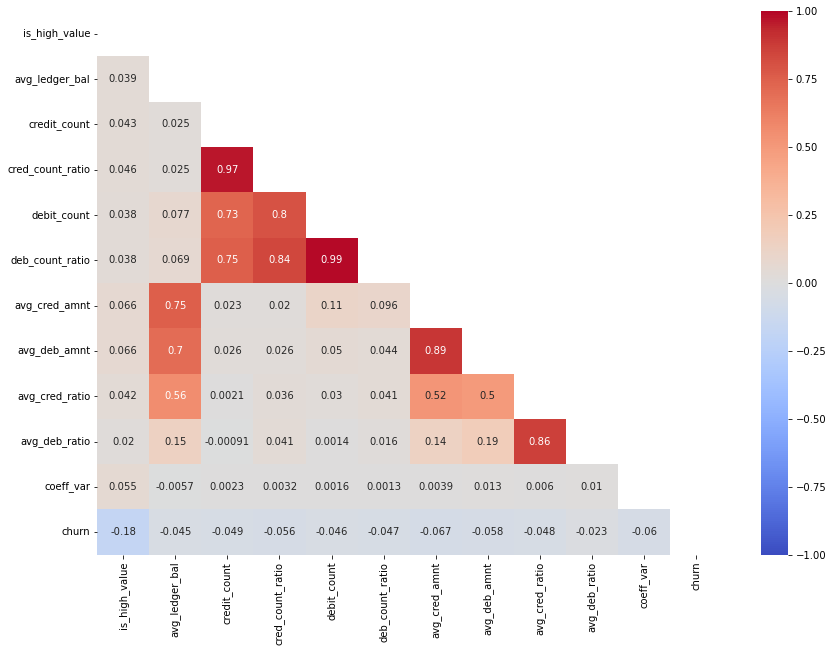

In [41]:
plt.figure(figsize = (14, 10))
corr = brass_v2.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr,
           cmap = 'coolwarm',
           vmin = -1,
           vmax = 1,
           annot = True,
           mask = mask);

Checking the correlation of our various numerical features, we see that the `debit_count_ratio` and `debit_count` are strongly correlated - 99%. Similar observation for `cred_count_ratio` and `credit_count` - 97%. These implies that the two pairs of strongly correlated features are linearly related to each other and would have similar effects on the target in our model. Consequently, I would drop the `credit_count` and `debit_count` columns. There are also strong correlations between the `avg_deb_amnt` and `avg_cred_amnt` as well as between `avg_deb_ratio` and `avg_cred_ratio`. These are not as high as for the other pairs considered, so I would leave those in the dataframe. That would leave us with 9 numerical predictor columns.

### Side note:
All of my numeric features do not appear to be correlated with the target variable `churn`. Would have been nice if we saw some correlation, but this does not necessarily imply that our model would be bad. Why? Because this is a classification - not regression - problem. Pearson correlation measures relationship of a linear nature between continuous variables, and our target is not continuous. 

In [42]:
#Dropping columns
brass_v2.drop(columns=['credit_count', 'debit_count'], inplace=True)

brass_v2.shape #we now have just 9 numerical features and our target column in the dataframe

(1493, 10)

In [43]:
#Merge in our categorical features
brass_v2 = brass_v2.merge(max_diff[['registration_type', 'industry']], on='id')

In [44]:
#checking
brass_v2.head()

,is_high_value,avg_ledger_bal,cred_count_ratio,deb_count_ratio,avg_cred_amnt,avg_deb_amnt,avg_cred_ratio,avg_deb_ratio,coeff_var,churn,registration_type,industry
id,,,,,,,,,,,,
21,0,5000.000,0.006,0.006,10000.000,10000.000,59.172,59.172,0.000,0,Enterprise,General Services
122,1,1000000.000,0.004,0.004,2000000.000,1200000.000,7662.835,4597.701,1.414,1,Limited Liability,Technology
159,1,212260332.479,0.037,0.266,254966666.667,35701682.828,1057952.974,148139.763,1.230,0,Sole Proprietorship,Technology
217,1,650000.000,0.005,0.005,1300000.000,1200000.000,5909.091,5454.545,1.414,1,Limited Liability,Digital Services
323,1,1974115.327,0.084,0.309,1131904.762,303603.649,4545.802,1219.292,0.816,0,Sole Proprietorship,Others


In [45]:
#I would like to move the `registration_type` and `industry` columns from the end - so I will rearrange columns
my_ordering = ['registration_type', 'industry', 'is_high_value', 
               'avg_ledger_bal', 'cred_count_ratio', 'deb_count_ratio', 
               'avg_cred_amnt', 'avg_deb_amnt', 'avg_cred_ratio', 'avg_deb_ratio', 'coeff_var', 'churn']

brass_v2 = brass_v2[my_ordering]

#check if it is merged and in the order i prefer - it is!
brass_v2.head()

,registration_type,industry,is_high_value,avg_ledger_bal,cred_count_ratio,deb_count_ratio,avg_cred_amnt,avg_deb_amnt,avg_cred_ratio,avg_deb_ratio,coeff_var,churn
id,,,,,,,,,,,,
21,Enterprise,General Services,0,5000.000,0.006,0.006,10000.000,10000.000,59.172,59.172,0.000,0
122,Limited Liability,Technology,1,1000000.000,0.004,0.004,2000000.000,1200000.000,7662.835,4597.701,1.414,1
159,Sole Proprietorship,Technology,1,212260332.479,0.037,0.266,254966666.667,35701682.828,1057952.974,148139.763,1.230,0
217,Limited Liability,Digital Services,1,650000.000,0.005,0.005,1300000.000,1200000.000,5909.091,5454.545,1.414,1
323,Sole Proprietorship,Others,1,1974115.327,0.084,0.309,1131904.762,303603.649,4545.802,1219.292,0.816,0


# Where we are

In this notebook, we generated almost a dozen features, eventually opting to drop a few of them and leaving us with our id column, 2 categorical features that remain from our original dataset, 9 newly engineered features, and a target feature - `churn` which we derived. 

## This is an updated dictionary containing our engineered columns

|**S/No**|**Feature**|**Description**|
|:---|:---|:---|
|1|`id`|Unique ID for each customer in the dataset|
|2|`registration_type`|Type of business entity based on registration of the customer|
|3|`industry`|Industry type for customer's business|
|4|`is_high_value`|a feature representing whether a customer is high or low value defined according to mean credit transactions|
|5|`avg_ledger_bal`|the average ledger balance per customer|
|6|`cred_count_ratio`|the count of `credit` transactions per number of days since registration per customer|
|7|`deb_count_ratio`|the count of `debit` transactions per number of days since registration per customer|
|8|`avg_cred_amnt`|the average credit amount per customer|
|9|`avg_deb_amnt`|the average credit amount per customer| 
|10|`avg_cred_ratio`|the average credit amount per customer per number of days since registration|
|11|`avg_deb_ratio`|the average debit amount per customer per number of days since registration| 
|12|`coeff_var`|the coefficient of variation of the `available_balance` for each customer|
|13|`churn`|did the customer churn or not - takes on a value of 0 for `not churn` and 1 for `churn`|

Going forward we would get into some preprocessing and modeling work, but before we leave let's export the `brass_v2` dataframe which contains all the columns we expect to use for our predictions at this time.

# Exporting `brass_v2`

In [46]:
brass_v2.to_csv('../data/brass_v2.csv')